# Import Modules

In [370]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.gridspec import GridSpec

from datetime import datetime, timedelta

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

In [371]:
df = pd.read_csv('Data/bank-full.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [372]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
df_vif = pd.DataFrame()
df_vif['vif_index'] = [vif(df.values,i) for i in range(df.shape[1])]
df_vif['features'] = df.columns
df_vif

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

# Exploratory Data Analysis (EDA)

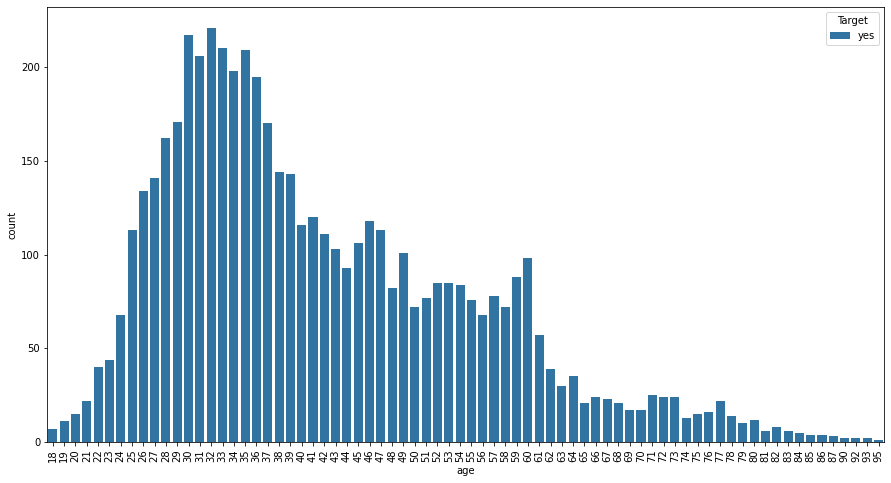

In [330]:
target = df[df['Target']=='yes']

plt.figure(figsize=(15,8))
sns.countplot(x='age', hue='Target', data=target)
plt.xticks(rotation=90);

In [331]:
def age_segmenting(x):
    if x>=18 and x<=25:
        return '18-25'
    
    elif x>25 and x<=40:
        return '25-40'
    
    elif x>40 and x<=65:
        return '40-65'
    
    else:
        return '65+'

df['age'] = df['age'].map(age_segmenting)

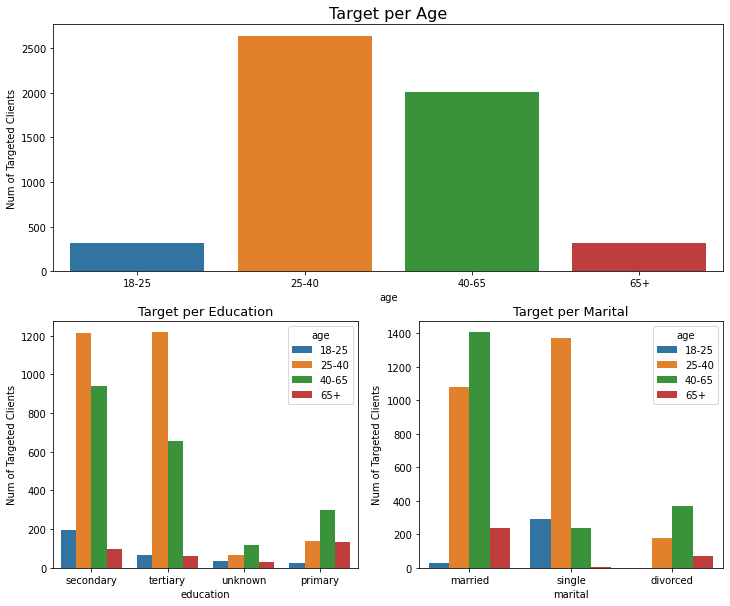

In [332]:
target = df[df['Target']=='yes']

fig = plt.figure(figsize=(12,10))
spec2 = GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec2[0, 0:])
ax2 = fig.add_subplot(spec2[1, 0])
ax3 = fig.add_subplot(spec2[1, 1])


ax1.set_title('Target per Age', size=16)
sns.countplot(x='age', order=['18-25','25-40','40-65','65+'], data=target, ax=ax1)
ax1.set_ylabel('Num of Targeted Clients')

ax2.set_title('Target per Education', size=13)
sns.countplot(x='education', hue='age', hue_order=['18-25','25-40','40-65','65+'], data=target, ax=ax2)
ax2.set_ylabel('Num of Targeted Clients')

ax3.set_title('Target per Marital', size=13)
sns.countplot(x='marital', hue='age', hue_order=['18-25','25-40','40-65','65+'], data=target, ax=ax3)
ax3.set_ylabel('Num of Targeted Clients')


plt.show()

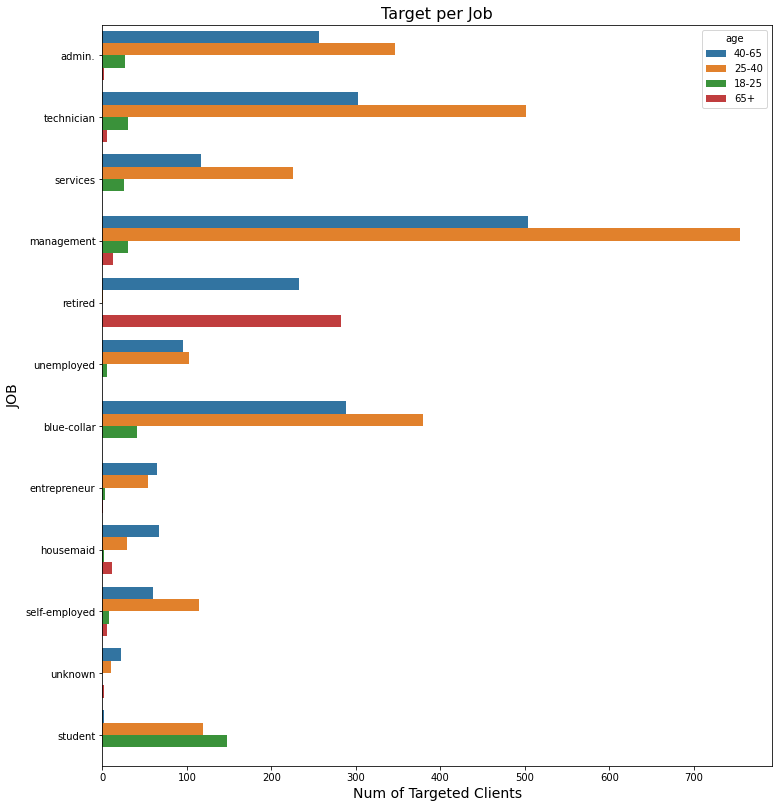

In [333]:
target = df[df['Target']=='yes']

fig = plt.figure(figsize=(12,30))
spec2 = GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(spec2[0, 0:])

ax1.set_title('Target per Job', size=16)
sns.countplot(y='job', hue='age', data=target, ax=ax1)
ax1.set_xlabel('Num of Targeted Clients', size=14)
ax1.set_ylabel(ax1.get_ylabel().upper(), size=14)

plt.show()

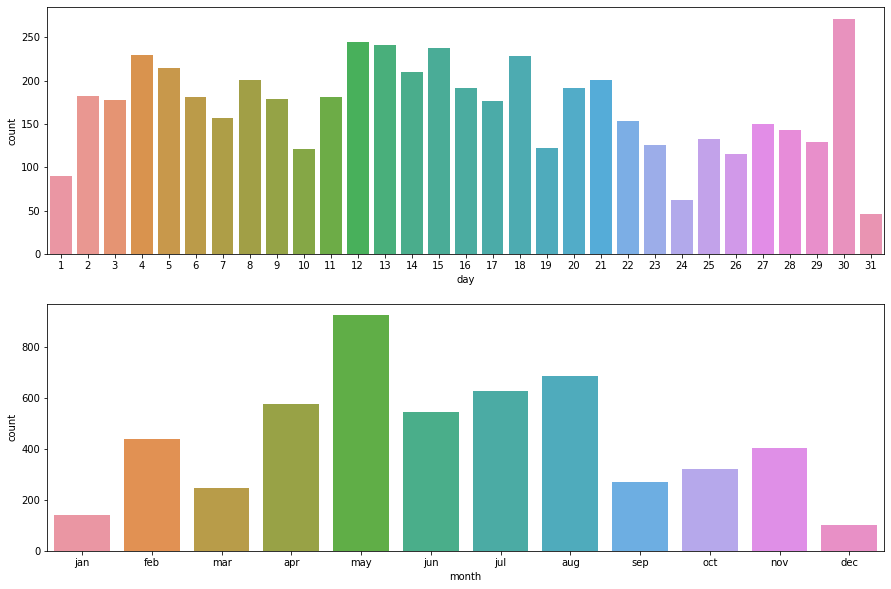

In [334]:
target = df[df['Target']=='yes']

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
sns.countplot(x='day', data=target)

plt.subplot(2,1,2)
sns.countplot(x='month', data=target, order=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec'])
plt.show()

# Preprocessing

## Converting Categorical values

In [335]:
def encoding_cat(data, *out):
    """This function converts all the categorical values of the DataFrame "data" into [0,1].
    
       It uses OneHotEncoder for multiple categorical values (>2)
       It uses LabelEncoder for binary categorical values
       
       - data: Pandas DataFrame
       - out: Columns of DataFrame that we don't want to convert
    """
    columns = data.keys()
    
    for col in columns:
        # Sometime not all the columns are need
        if col not in out:
            labels = list(data[col].unique())
            labels.sort()
            
            if 'unknown' in labels:
                labels[labels.index('unknown')] = f'unknown_{col}'
            
            # Only with categorical values
            if isinstance(labels[0], str):
                
                # OneHotEncoder
                if len(labels)>2:
                    ohe = OneHotEncoder(sparse=False)
                    data[labels]=ohe.fit_transform(data[[col]])
                    data.drop(columns=col, inplace=True)
                
                # LabelEncoder
                else:
                    le = LabelEncoder()
                    data[col]=le.fit_transform(data[col])
    return data

df = encoding_cat(df, 'month')

In [336]:
df.head(2)

,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,...,secondary,tertiary,unknown_education,cellular,telephone,unknown_contact,failure,other,success,unknown_poutcome
0,0,2143,1,0,5,may,261,1,-1,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0,29,1,0,5,may,151,1,-1,0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


## Converting date to cyclic value

In [337]:
df['date'] =  pd.to_datetime(df['month'] +' '+ df['day'].astype(str) + ' 2021', format=('%b %d %Y'))
df.drop(columns =['day','month'], inplace=True)

days_per_month = 365.25/12
df['date'] = df['date'].dt.month + df['date'].dt.day/days_per_month

# Cyclic !
df['date'] = np.sin(df['date']/df['date'].max())

In [338]:
df.head(2)

,default,balance,housing,loan,duration,campaign,pdays,previous,Target,18-25,...,tertiary,unknown_education,cellular,telephone,unknown_contact,failure,other,success,unknown_poutcome,date
0,0,2143,1,0,261,1,-1,0,0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.386365
1,0,29,1,0,151,1,-1,0,0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.386365


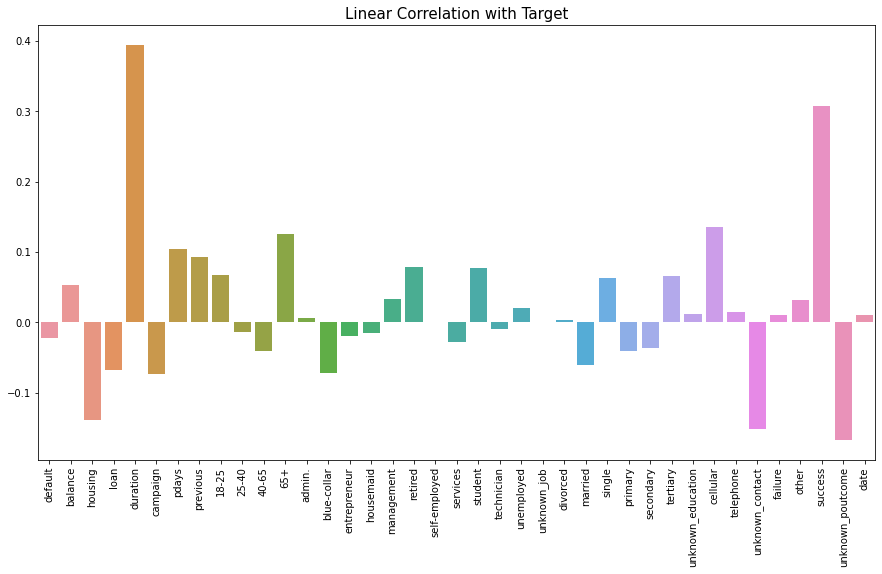

In [339]:
corr = df.corr()['Target'].drop('Target')

plt.figure(figsize=(15,8))
plt.title('Linear Correlation with Target', size=15)
sns.barplot(x =corr.keys(), y = corr.values)
plt.xticks(rotation=90)
plt.show()

# Models

In [351]:
X = df.drop(columns='Target')
y = df['Target']

In [352]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [353]:
feat = ['balance','duration', 'campaign','pdays', 'previous']

rb = RobustScaler().fit(X_train)
X_train = rb.transform(X_train)
X_test = rb.transform(X_test)

In [354]:
X_train.shape

(31647, 39)

## Baseline

In [355]:
y_pred = np.zeros((len(df),))
y_true = df['Target']

baseline = accuracy_score(y_true, y_pred)
print(f'Baseline Score: {round(baseline*100,2)} %')

Baseline Score: 88.3 %


## Logistic

In [358]:
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [360]:
y_pred = lr.predict(X_test)
print(f'Score: {round(accuracy_score(y_test, y_pred)*100,2)} %')

Score: 89.91 %


## SVM

In [364]:
svm = SVC(kernel='poly')
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [365]:
y_pred = svm.predict(X_test)
print(f'Score: {accuracy_score(y_test, y_pred)*100} %')

Score: 88.39575346505455 %
